## An Introduction to Quantopian's Research Platform

I wanted to introduce you guys to the kinds of things you can do on Quantopian's Research Platform. I'm not going to be finding anything super significant that we'd be able to apply directly into an algorithm - this is just meant to give you guys a taste of how research works. I'm going to work with some of Quantopian's API along with third party libraries like pandas, numpy & matplotlib to examine arbitrary bits of data. Hopefully by the end of this you'll get a sense of how we can aggregate these types of tools to build a successful trading algorithm.

In [1]:
# Let's start by importing some libraries
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels import regression
import statsmodels.api as sm
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data import Fundamentals
from quantopian.pipeline.factors import Latest
from quantopian.research import run_pipeline

Let's take a look into the top 100 companies (ranked by market capitilization).

We'll be doing this through Pipeline. Pipeline allows you to efficiently grab data that fits your criteria.
It's worth reading more [here](https://www.quantopian.com/tutorials/pipeline#lesson1).

It's also worth noting that we're looking at a very narrow band of information.
For statistically significant analysis, we'd have to look at factors over the course of many months or years.
I did it this way so if you want to follow along or play with these things in your own environment,
the calculations would be quick.

In [2]:
# Our 'trading' universe will be limited to the top 100 companies ranked by market cap
universe = Fundamentals.market_cap.latest.top(100)

# Find top 100 companies for the month of October 2017.
# Note that this will return the top 100 companies for every trading day in October at the closing price
pipe = Pipeline(
        columns = {
            'market_cap':Fundamentals.market_cap.latest
        },
        screen=universe
    )
result = run_pipeline(pipe, '2017-10-01', '2017-10-31')

In [3]:
# Get market cap on October 2nd (October 1st is a Sunday - not a trading day)
# We're doing this by taking the first 100 data points outputed by Pipeline and sorting 
# them in descending order (i.e. highest market cap (AAPL) is at the top)
Oct_02 = result.iloc[:100].sort_values('market_cap', ascending=False)

# See stock and market cap
# head() is a useful pandas method that can be used to peek at the contents of a pandas 'DataFrame' or 'Series'
# (You can think of a DataFrame as an array of arrays and a Series as an array, although they
# have tools that make them much more powerful than just a simple data structure)
print 'Stock and market cap \n{} \n'.format(Oct_02.head())

# I'm going to use a python list comprehension to get the security ids of these top 100 companies
# Note that we could have gotten the Equity object with just 'equity[1]'
# We'll be using these ids to get pricing information later on
Oct_02_top_100_sids = [equity[1].sid for equity in Oct_02.index.values]
print 'Security ids: \n{} \n'.format(Oct_02_top_100_sids)

# Just get the market cap
print 'List of market caps \n{}'.format(Oct_02.head().values)

Stock and market cap 
                                                    market_cap
2017-10-02 00:00:00+00:00 Equity(24 [AAPL])       7.960649e+11
                          Equity(46631 [GOOG])    6.695902e+11
                          Equity(26578 [GOOG_L])  6.695902e+11
                          Equity(5061 [MSFT])     5.737402e+11
                          Equity(42950 [FB])      4.962401e+11 

Security ids: 
[24, 46631, 26578, 5061, 42950, 16841, 1091, 11100, 47740, 4151, 8347, 25006, 8151, 700, 27487, 27470, 35920, 6653, 8229, 5938, 38554, 23112, 5923, 3149, 25066, 21439, 21839, 5692, 21536, 20373, 1335, 3496, 4283, 7792, 17773, 1637, 3951, 7543, 5029, 35902, 7784, 7767, 1900, 51157, 5885, 2190, 50307, 32146, 698, 25298, 43694, 368, 3766, 7538, 19250, 4707, 19675, 4922, 23912, 4954, 5511, 44616, 1406, 13732, 7143, 25766, 49557, 25090, 863, 19725, 49556, 3212, 4758, 980, 15596, 20940, 45840, 22169, 38650, 43604, 27768, 27769, 46850, 35469, 44629, 27190, 3242, 6928, 49229, 4487, 25

I want to do a little thought experiment here. Let's say we had a really simple investment strategy - buy the top 100 companies ranked by market cap and hold onto them. If we were testing this strategy for the month of October, note that we'd have to buy our stocks based on the values on October 1st (or 2nd since thats the first trading day of the month). In real life, we don't have the luxury of seeing what the 100 most valuable companies will be come October 31st, but on Quantopian, we do. Because we have access to that kind of information in the research environment, it's really important to make sure we don't introduce look ahead bias. (Of course your strategy would do amazing - it already knew what the end result would be ahead of time!). In this example its trivial to see that we didn't do this or wouldn't want to do this, but as we introduce more and more data and our methods become more complex, this can be an pitfall. There are other things we'll be on the lookout for but in my mind this is the easiest error to make.

In [4]:
# Let's grab day to day stock pricing information
# We have access to things like open price, high, low and volume, 
# but for simplicity sake we'll just examine closing price
prices = get_pricing(Oct_02_top_100_sids, fields='price', start_date='2017-10-01', end_date='2017-10-31')

# Let's get SPY data as well do to some comparisons
# SPY is an Exchange Traded Fund that tracks the S&P 500 Index
# SPY is the stereotypical benchmark to beat since it's pretty much 'the market'
prices_SPY = get_pricing('SPY', fields='price', start_date='2017-10-01', end_date='2017-10-31')

print "Here's what the pricing data looks like: \n\n{}".format(prices_SPY)

Here's what the pricing data looks like: 

2017-10-02 00:00:00+00:00    252.280
2017-10-03 00:00:00+00:00    252.850
2017-10-04 00:00:00+00:00    253.170
2017-10-05 00:00:00+00:00    254.650
2017-10-06 00:00:00+00:00    254.400
2017-10-09 00:00:00+00:00    253.950
2017-10-10 00:00:00+00:00    254.600
2017-10-11 00:00:00+00:00    255.000
2017-10-12 00:00:00+00:00    254.610
2017-10-13 00:00:00+00:00    254.920
2017-10-16 00:00:00+00:00    255.300
2017-10-17 00:00:00+00:00    255.460
2017-10-18 00:00:00+00:00    255.700
2017-10-19 00:00:00+00:00    255.820
2017-10-20 00:00:00+00:00    257.089
2017-10-23 00:00:00+00:00    256.140
2017-10-24 00:00:00+00:00    256.550
2017-10-25 00:00:00+00:00    255.300
2017-10-26 00:00:00+00:00    255.580
2017-10-27 00:00:00+00:00    257.690
2017-10-30 00:00:00+00:00    256.800
2017-10-31 00:00:00+00:00    257.110
Freq: C, Name: Equity(8554 [SPY]), dtype: float64


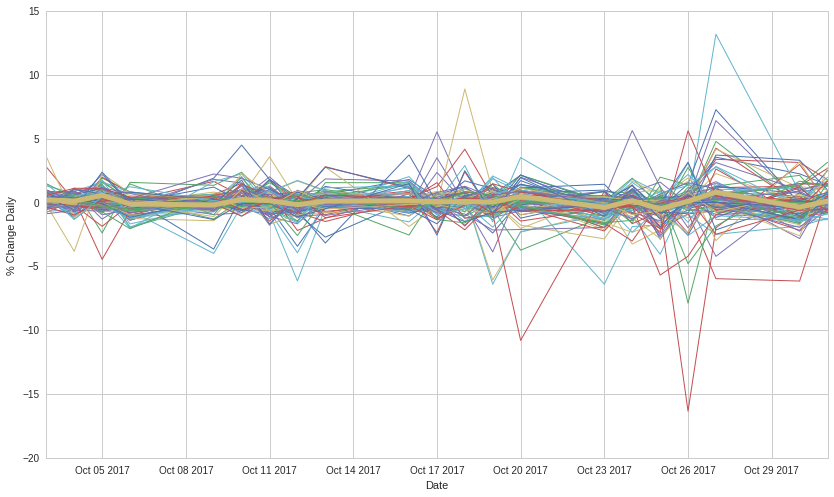

In [5]:
# Let's calculate the percent change in price (per day)
# We have the [1:] to kick out the 1st value
# (1st value is NaN because we don't have a return the first day)
prices_return = prices.pct_change()[1:]
prices_SPY_return = prices_SPY.pct_change()[1:]
# Let's make a pretty graph
plt.plot(prices_return.index, prices_return.values*100, linewidth=1)
plt.plot(prices_SPY_return.index, prices_SPY_return.values*100, linewidth=5)
plt.ylabel('% Change Daily')
plt.xlabel('Date')

Obviously the movements in the top 100 companies is highly correlated to the movements by the market (SPY is the big line in yellow) - they basically make up the market! We can compute this relationship through Linear Regression.

In [6]:
# Let's define our function that will perform linear regression and plot the results
def linreg(X,Y):
    # Running the linear regression using a simple ordinary least squares model
    X = sm.add_constant(X)
    model = regression.linear_model.OLS(Y, X).fit()
    a = model.params[0]
    b = model.params[1]
    X = X[:, 1]

    # Return summary of the regression and plot results
    X2 = np.linspace(X.min(), X.max(), 100)
    Y_hat = X2 * b + a
    plt.scatter(X, Y, alpha=0.3) # Plot the raw data
    plt.plot(X2, Y_hat, 'r', alpha=0.9);  # Add the regression line, colored in red
    plt.xlabel('X Value')
    plt.ylabel('Y Value')
    return model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     237.2
Date:                Sun, 12 Nov 2017   Prob (F-statistic):           4.30e-44
Time:                        23:41:23   Log-Likelihood:                 1552.7
No. Observations:                 503   AIC:                            -3101.
Df Residuals:                     501   BIC:                            -3093.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0003      0.000      0.561      0.575        -0.001     0.001
x1             1.0902      0.071     15.400      0.000         0.951     1.229
==============================================================================
Omnibus:                       94.563   Durbin-Watson:                   1.762
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1398.174
Skew:                           0.268   Prob(JB):                    2.46e-304
Kurtosis:                      11.150   Cond. No.                         143.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

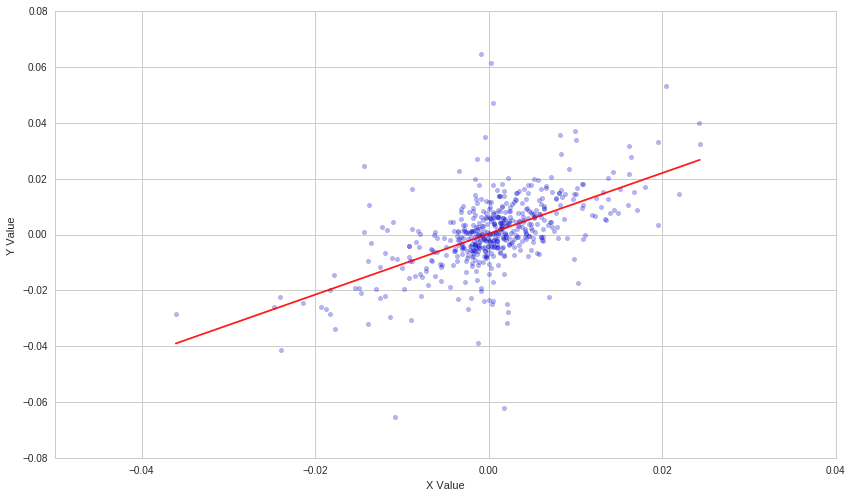

In [7]:
# As an example, we'll perform a regression on AAPL and SPY
# Since a looking over a month only gives ~20 data points, we're going to expand our starting
# and ending dates to get more statistically significant data
# Let's look at the past couple of years to paint a 'fuller' picture
asset = get_pricing('AAPL', fields='price', start_date='2015-10-31', end_date='2017-10-31')
benchmark = get_pricing('SPY', fields='price', start_date='2015-10-31', end_date='2017-10-31')

# We have to take the percent changes to get to returns
# Get rid of the first (0th) element because it is NAN
asset_pct = asset.pct_change()[1:]
benchmark_pct = benchmark.pct_change()[1:]

linreg(benchmark_pct.values, asset_pct.values)

SPY returns are on the x axis and AAPL returns are on the y axis. As you can see from the graph, there's an effectively linear relationship between what happens in the broader market and what happens with Apple. The important numbers to take away from the table are the 4.30e-44 from Prob (F-statistic) and the 1.0902 from x1 coef. We want the F-statistic to be very low, at minimum less than .05, so that we know there's statistical significance in what were looking at. The second number is the Beta, how correlated our asset is compared to the benchmark. In this case, AAPL is slightly more volatile than SPY. (Beta = 1 means movements in the stock are perfecly correlated to movements in the market - if SPY went up 1%, our asset would too. Beta = 0 means our returns are uncorrelated to what's going on in the market - this is what we'll be aiming for.)

If you haven't looked at Quantopian's Lectures yet, I hope this was a smooth introduction into what you can do in Research Notebooks. It's worth looking into the first 10 or so Quantopian Lectures available [here](https://www.quantopian.com/lectures) to get a better sense of what's out there.